### Imports and Config

In [1]:
import pathlib
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import pytorch_lightning as pl
import torchmetrics

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sambhav-chandra (metacognition). Use `wandb login --relogin` to force relogin


True

In [4]:
print(f"Pytorch Version: {torch.__version__}")
print(torch.__config__.show())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Pytorch Version: 1.13.1
PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.5
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /w /bigob

### Dataset

In [5]:
#DATA = pathlib.Path("/media/sambhav/30AC4696AC46568E/datasets")

DATA = pathlib.Path.home() / "datasets"
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, ), (.5,))])

train_dataset = datasets.FashionMNIST(
    root = DATA.as_posix(),
    #download = True,
    train = True,
    transform = transforms
)

test_dataset = datasets.FashionMNIST(
    root = DATA.as_posix(),
    train = False,
    transform= transforms
)

torch.Size([1, 28, 28])
cpu


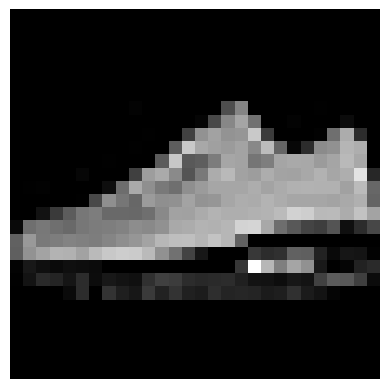

In [6]:
idx = torch.randint(1, len(train_dataset), (1,)).item()
img, label = train_dataset.__getitem__(idx)
plt.axis('off')
plt.imshow(img.squeeze(), cmap = 'gray')
print(img.shape)
print(img.device)

### Model

In [42]:
class TinyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Flatten(start_dim = 1, end_dim = -1)
        self.linear1 = nn.Linear(28 * 28, 1000)
        self.linear2 = nn.Linear(1000, 512)
        self.linear3 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.input(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class TinyClassifier(pl.LightningModule):
    def __init__(self, model, learning_rate, ):
        super().__init__()
        self.model = model  
        self.save_hyperparameters(ignore=["model"])
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes=10)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _shared_evaluation_step(self, batch, batch_idx):
        data, targets = batch
        prediction = self.model(data) 
        loss = self.criterion(prediction, targets)
        accuracy = self.accuracy(prediction, targets) * 100
        return loss, accuracy

    def training_step(self, batch, batch_idx):
        #data, targets = batch
        #prediction = self.model(data) 
        #loss = self.criterion(prediction, targets)
        loss, _ = self._shared_evaluation_step(batch, batch_idx)
        self.log("train/loss", loss, on_epoch=True, prog_bar=True, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self._shared_evaluation_step(batch, batch_idx)
        metrics = {"val/loss": loss, "val/accuracy": accuracy}
        self.log_dict(metrics)
        #self.log("val/loss", loss, on_epoch=True, prog_bar=True, logger = True)
        #self.log("test/accuracy", self.val_accuracy(prediction, targets)*100, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        loss, accuracy = self._shared_evaluation_step(batch, batch_idx)
        metrics = {"test/loss": loss, "test/accuracy": accuracy}
        self.log_dict(metrics)
        #self.log("test/loss", loss, on_epoch=True, prog_bar=True, logger = True)
        #self.log("test/accuracy", self.test_accuracy(prediction, targets)*100, on_epoch=True, prog_bar=True, logger=True)
 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.hparams.learning_rate)
        return optimizer

### Trainer

In [43]:
#HYPERPARAMETERS
class Config():
    def __init__(self, num_epochs, batch_size, learning_rate, seed):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.seed = seed

        self.num_workers = 4
    
    def log_config(self):
        config_dictionary = {
            "num_epochs" : self.num_epochs,
            "batch_size" : self.batch_size,
            "learning_rate" : self.learning_rate,
            "seed": self.seed
        }
        return config_dictionary

config = Config(10, 64, 1e-3, seed = 69420)

In [44]:
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    num_workers = config.num_workers)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = config.batch_size,
    num_workers = config.num_workers
)

In [45]:
classifier = TinyClassifier(TinyModel(), config.learning_rate)
print(classifier.hparams)

"learning_rate": 0.001


In [32]:
classifier = TinyClassifier(TinyModel(), config.learning_rate)
trainer = pl.Trainer(accelerator = "gpu", 
                     max_epochs = config.num_epochs, 
                     limit_train_batches = 0.2)

trainer.fit(classifier, train_loader)
trainer.test(classifier, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | TinyModel          | 1.3 M 
1 | accuracy  | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.211     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy          85.1500015258789
        test/loss           0.4214544892311096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.4214544892311096, 'test/accuracy': 85.1500015258789}]